In [1]:
from data import*
from regression import*

Using TensorFlow backend.


# DATA

In [2]:
synth_data = DATA( dataset_name='synth', features=['synth_vind_1', 'synth_vind_2'], target='center_1')
synth_data = synth_data.standardize()
train_synth_data, test_synth_data = synth_data.split(ratio=.7)

print(np.shape(train_synth_data.X), np.shape(train_synth_data.Y))
print(np.shape(test_synth_data.X), np.shape(test_synth_data.Y))

(700, 334, 2) (700, 334)
(300, 334, 2) (300, 334)


# RNN

In [76]:
class REGRESSOR(object):
    
    def __init__(self, win_size, Nfeatures, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.Nfeatures = Nfeatures
        self.build_model(**params)
        
    
    def train(self, train_data, step=None, epochs=100, verbose=0, show=True):    
        if step is None: step = self.win_size    
        
        loss = list()        
        for n_epoch in range(epochs):
            display(n_epoch)            
            ep_loss = list()            
            for i in range(0, np.shape(train_data.X)[1]-self.win_size, step):
                history = self.model.fit( 
                    train_data.X[:, i:i+self.win_size,:], 
                    train_data.Y[:, i+self.win_size-1], 
                    epochs = 1, 
                    verbose = verbose)    
                ep_loss.append(history.history['loss'])            
            loss.append(ep_loss)
            clear_output(wait=True)
            
            if show:
                plt.plot( np.ndarray.flatten( np.array(loss)) )
                plt.show()                
        return np.array(loss)

    
    def predict(self, X, window_length=None):
        predictions = list()
        for x in X:
            pred = np.array([self.model.predict( np.reshape(x[t:t+self.win_size,:],[1,self.win_size, -1]) ) for t in range(np.shape(x)[0]-self.win_size)]).flatten()
            if window_length is not None: pred = signal.savgol_filter( pred, window_length=window_length, polyorder=1)       
            predictions.append( pred )  
        return predictions 
    

# ------------------------------------------   
class RNN(REGRESSOR):
    def build_model(self, Nunits=3, NhiddenLayers=1, activation='softmax', optimizer='RMSprop', loss='mean_squared_error', dropout=0):
        
        self.model = Sequential()           
        self.model.add( LSTM(units=Nunits, input_shape=(self.win_size, self.Nfeatures), return_sequences=True, dropout=dropout) )    
        for n in range(NhiddenLayers): 
            self.model.add( LSTM(units=Nunits, return_sequences=True, dropout=dropout) )        
        self.model.add( LSTM(units=Nunits, dropout=dropout))   
        self.model.add( Dense(1, activation=activation))                      
        self.model.compile(loss=loss, optimizer=optimizer)  

        print(self.model.summary())        
        return 
 
 model = Sequential()  
model.add(LSTM(in_out_neurons, hidden_neurons, return_sequences=False))  
model.add(Dense(hidden_neurons, in_out_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# ------------------------------------------   
class TCN(REGRESSOR):
    def build_model(self, Nlayers=2, nb_filters=5, Nfeatures=2, activation=None, optimizer='adam', loss='mse' ):  
        i = tf.keras.Input(batch_shape=(None, self.win_size, Nfeatures)) 
        if Nlayers>1:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=True)(i)
            for n in range(Nlayers-2): tcn.TCN(nb_filters=nb_filters, return_sequences=True)(o)    
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(o)
        else:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(i)     
            
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])
        
        self.model.compile(loss='mse', optimizer='adam')
        
        print(self.model.summary())                
        return 

#### Build Model

In [77]:
regressor = RNN(
    win_size = 20,
    Nunits = 10, 
    NhiddenLayers = 5,
    activation = 'softmax',
    optimizer = 'adam', 
    loss = 'mean_squared_error', 
    dropout = 0,
    Nfeatures = train_synth_data.X.shape[2]
)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_206 (LSTM)              (None, 20, 10)            520       
_________________________________________________________________
lstm_207 (LSTM)              (None, 20, 10)            840       
_________________________________________________________________
lstm_208 (LSTM)              (None, 20, 10)            840       
_________________________________________________________________
lstm_209 (LSTM)              (None, 20, 10)            840       
_________________________________________________________________
lstm_210 (LSTM)              (None, 20, 10)            840       
_________________________________________________________________
lstm_211 (LSTM)              (None, 20, 10)            840       
_________________________________________________________________
lstm_212 (LSTM)              (None, 10)              

#### Training

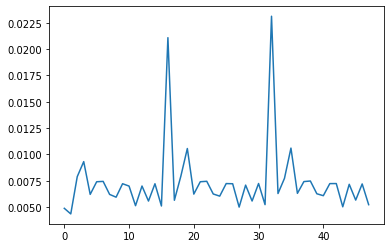

In [78]:
loss = regressor.train(train_synth_data, step=None, epochs=3)

#### Validation

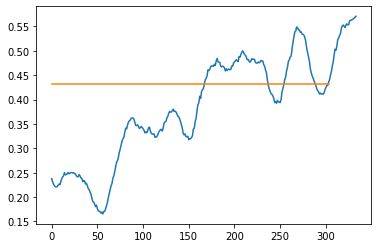

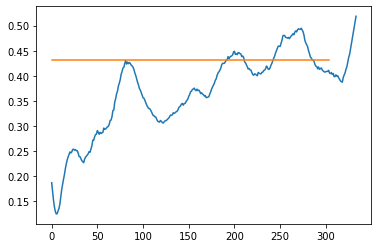

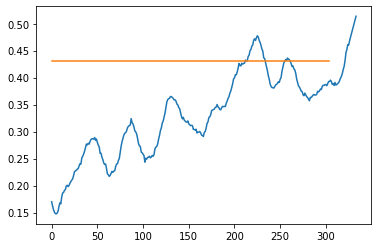

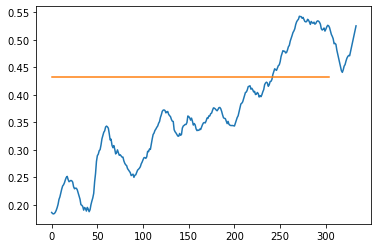

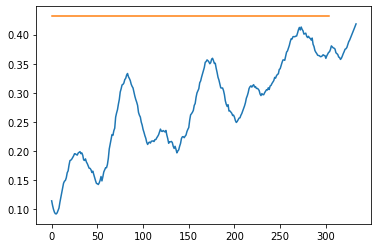

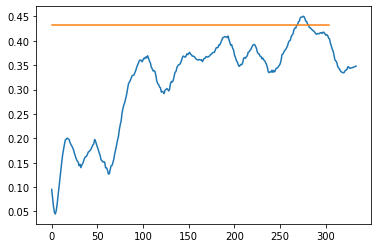

In [79]:
data,_ = test_synth_data.split(ratio=.02)
# data = DATA( dataset_name='arduino', features=['synth_vind_1', 'synth_vind_2'], target='center_1')
# data = DATA( dataset_name='arduino', features=['vind_1', 'vind_2'], target='center_1')


# predictions = regressor.predict(data.X)

for (y_true, y_pred) in zip(data.Y, predictions):
    # y_pred = signal.savgol_filter( y_pred, window_length=11, polyorder=1, axis=0)       
    plt.plot(y_true, label='Target')
    plt.plot(y_pred, label='Prediction')
    plt.show()

# TCN

#### Build Model

In [53]:
regressor = TCN(
    win_size = 20,
    step = 1,
    Nlayers = 1,
    nb_filters=64,
    activation = None, 
    optimizer = 'adam', 
    loss = 'mse',
    Nfeatures = train_data.X.shape[2]  
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 4)]           0         
_________________________________________________________________
tcn_4 (TCN)                  (None, 2)                 138       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
None


#### Training

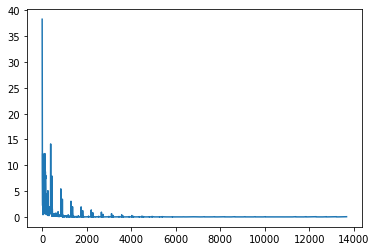

In [54]:
loss = regressor.train( train_data, epochs=30 )

#### Validation

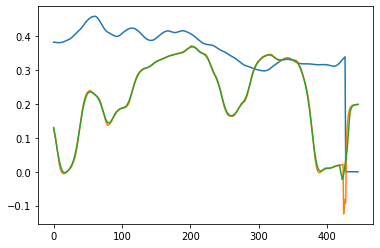

In [58]:
idx = 2
data = train_data

x, y = data.X[idx], data.Y[idx]
x = np.reshape(x, (1, np.shape(x)[0], np.shape(x)[1]))
y = np.reshape(y, (1, np.shape(y)[0]))

predictions = regressor.predict(x)
smoothed_predictions = signal.savgol_filter( predictions[0], window_length=11, polyorder=1, axis=0)       

plt.plot(y[0,regressor.win_size:])
plt.plot(predictions[0])
plt.plot(smoothed_predictions)
plt.show()

In [ ]:
class REGRESSOR(object):
    
    def __init__(self, win_size, Nfeatures, step=1, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.Nfeatures = Nfeatures
        self.step = step                
        self.build_model(**params)
        
    
    def train(self, train_data, epochs=100, verbose=0, show=True):        
        loss = list()        
        for n_epoch in range(epochs):
            display(n_epoch)
            
            ep_loss = list()            
            for i in range(0, np.shape(train_data.X)[1]-self.win_size, self.step):
                history = self.model.fit( 
                    train_data.X[:, i:i+self.win_size,:], 
                    train_data.Y[:, i+self.win_size-1], 
                    epochs = 1, 
                    verbose = verbose
                )    
                ep_loss.append(history.history['loss'])
            
            loss.append(ep_loss)
            clear_output(wait=True)
            
            if show:
                plt.plot( np.ndarray.flatten( np.array(loss)) )
                plt.show()
                
        return np.array(loss)

    
    def predict(self, X):
        predictions = list()
        for x in X:
            pred = np.array([ self.model.predict(x[t:t+self.win_size,:]) for t in range(np.shape(x)[0]-self.win_size) ])
            predictions.append(pred)
        
        return predictions 
    

# ------------------------------------------   
class RNN(REGRESSOR):
    def build_model(self, Nunits=3, NhiddenLayers=1, activation='linear'):
        
        self.model = Sequential()           
        self.model.add( LSTM(units=Nunits, activation=activation, return_sequences=True, input_shape=(self.win_size, self.Nfeatures)) )    
        for n in range(NhiddenLayers): self.model.add( LSTM(units=Nunits, activation=activation, return_sequences=True) )        
        self.model.add( LSTM(units=Nunits, activation=activation))   
#         self.model.add(Dropout(0.1))
        self.model.add( Dense(1))                      
        self.model.compile(loss='mse', optimizer='adam')  

        print(self.model.summary())        
        return 
 

# ------------------------------------------   
class TCN(REGRESSOR):
    def build_model(self, Nlayers=2, nb_filters=5, Nfeatures=2, activation=None, optimizer='adam', loss='mse' ):  
        i = tf.keras.Input(batch_shape=(None, self.win_size, Nfeatures)) 
        if Nlayers>1:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=True)(i)
            for n in range(Nlayers-2): tcn.TCN(nb_filters=nb_filters, return_sequences=True)(o)    
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(o)
        else:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(i)     
            
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])
        
        self.model.compile(loss='mse', optimizer='adam')
        
        print(self.model.summary())                
        return 

In [ ]:
# eps = 1e-12
# class DATA(object):    
#     # ---------------------------------------------------------------------------------------------------   
#     def __init__(self, database_name, target, features, records_numbers=None):            
#         self.X, self.Y = list(), list()     
#         self.load(database_name, target, features, records_numbers=records_numbers)
#         return
#     # ---------------------------------------------------------------------------------------------------       
#     def load(self, database_name, target, features, records_numbers=None):
#         if records_numbers is None:
#             folder_path = os.path.dirname( get_dataset_file_path(database_name,'') )   
#             file_path_list = list(Path(folder_path).glob('*.pkl'))
#         else:
#             file_path_list = [get_dataset_file_path(database_name, 'record_'+"{0:0=2d}".format(n)) for n in records_numbers]
            
#         for file_path in file_path_list:                 
#             data = pd.read_pickle( file_path )

#             y = data.filter(regex=target, axis=1).values  
#             x = [data.filter(regex=feature, axis=1).values for feature in features]            
            
#             # lists
#             self.X.append( np.concatenate(x, axis=1) )
#             self.Y.append( y.reshape((len(y))) )

#         X = np.array(self.X)
#         Y = np.array(self.Y)
#         return
#     # ---------------------------------------------------------------------------------------------------       
#     def merge(self, new_dataset):
#         merged_dataset = copy.deepcopy(self)
#         merged_dataset.X = np.array([*self.X, *new_dataset.X])
#         merged_dataset.Y = np.array([*self.Y, *new_dataset.Y])
#         return merged_dataset
#     # ---------------------------------------------------------------------------------------------------       
#     def select(self, idx_list):
#         selected_dataset = copy.deepcopy(self)
#         selected_dataset.X = self.X[idx_list]
#         selected_dataset.Y = self.Y[idx_list]
#         return selected_dataset
#     # ---------------------------------------------------------------------------------------------------
#     def split(self, ratio):
#         N = len(self.X)
#         idxs = np.arange(N)
#         random.shuffle(idxs)
        
#         Ntrain = int(N*ratio)
#         data_p1 = self.select(idxs[:Ntrain])
#         data_p2 = self.select(idxs[Ntrain:])
        
#         return data_p1, data_p2
#     # ---------------------------------------------------------------------------------------------------       
#     def mtx( self, Nt_mtx='max' ):  
#         # This function padds or cuts all input data (X) to make them same length and generate matrix data(X_mtx)
#         # it also nomalize data X-mean(X)
#         data_mtx = copy.deepcopy(self)
#         if len(np.shape(data_mtx.X))>1:  return data_mtx    

#         Nt_list = [np.shape(x)[0] for x in self.X]
#         Nt = int( eval('np.' + Nt_mtx)(Nt_list) )
#         Nd, Nf = len(self.X),  np.shape(self.X[0])[1]
        
#         data_mtx.X = np.zeros( (Nd,Nt,Nf) )
#         data_mtx.Y = np.zeros( (Nd,Nt) )
        
#         for idx, x in enumerate(self.X): 
#             nt = np.shape(x)[0]
            
#             if Nt >= nt:
#                 data_mtx.X[idx,:,:] = np.pad( x, ((0,Nt-nt),(0,0)),'constant')
#                 data_mtx.Y[idx,:nt] = self.Y[idx]
                
#             else:
#                 data_mtx.X[idx,:,:] = x[:Nt,:]
#                 data_mtx.Y[idx, :] = self.Y[idx][:Nt]
#         return data_mtx
#     # ---------------------------------------------------------------------------------------------------   
#     def bound(self, min_value=None, max_value=None):
#         # This function limits the amplitude value 
        
#         bounded_data = copy.deepcopy(self)
#         if min_value is not None:
#             for x in bounded_data.X: x[ x<min_value ] = min_value
#         if max_value is not None:                
#             for x in bounded_data.X: x[ x>max_value ] = max_value
        
#         return bounded_data
#     # ---------------------------------------------------------------------------------------------------   
#     def trim(self, keep_ratio=None):
#         trimmed_data = copy.deepcopy(self)
#         trimmed_data.X = list()
        
#         if keep_ratio is None:
#             dt = 20   
#             for x in self.X:     
#                 N = len(x)
#                 n1, n2 = dt, N-dt 
#                 xx = abs( np.diff(x))
#                 xx = np.sum(xx, axis=1)    
#                 xx = abs(np.diff(xx))
#                 xx /= ( np.nanmax(xx) + eps )                 
#                 idxs = np.where( xx > 0.5 )[0]    
#                 idxs1 = idxs[idxs < 0.5*N] 
#                 idxs2 = idxs[idxs > 0.5*N]      
#                 if np.any(idxs1): n1 = np.min(idxs1) + dt
#                 if np.any(idxs2): n2 = np.max(idxs2) - dt   
#                 if (n2-n1) < 0.5*N: n1, n2 = 0, N            
#                 trimmed_data.X.append( x[n1:n2,:] )
#         else:   
#             for x in self.X:
#                 L = int( len(x) * keep_ratio)
#                 trimmed_data.X.append( x[:L,:] ) 

#         trimmed_data.X = np.array(trimmed_data.X)    
#         return trimmed_data    
#     # ---------------------------------------------------------------------------------------------------      
#     def quantize(self, Qstep):        
#         quantized_data = copy.deepcopy(self)
#         for idx, x in enumerate(quantized_data.X): 
#             quantized_data.X[idx] = Qstep * np.floor(x/Qstep)
#         return quantized_data   
#     # ---------------------------------------------------------------------------------------------------   
#     def clean(self):
#         # cleans data from NANs ! 
#         cleaned_data = copy.deepcopy(self)
#         for idx, x in enumerate(cleaned_data.X):
#             if np.any(np.isnan(x)):
#                 df = pd.DataFrame(x)
#                 df = df.fillna(method='ffill', axis=0).bfill(axis=0)      
#                 cleaned_data.X[idx] = df.as_matrix()

#         return cleaned_data                
#     # ---------------------------------------------------------------------------------------------------   
#     def filter_noise(self, window_length=5, polyorder=2):
#         filtered_data = copy.deepcopy(self)
#         for n, x in enumerate(self.X):
#             for i in range(8):
#                 filtered_data.X[n][:,i] = signal.savgol_filter(x[:,i], window_length, polyorder)        
#         return filtered_data
#     # ---------------------------------------------------------------------------------------------------   
#     def MinMax(self):
#         # Rescale data value to (0,1)
#         normalized_data = copy.deepcopy(self)
#         for idx, x in enumerate(normalized_data.X): 
#             MIN = np.nanmin(x,axis=0)
#             MAX = np.nanmax(x,axis=0)
#             normalized_data.X[idx] = np.subtract(x,MIN) / ( np.subtract(MAX,MIN) + eps )
#         return normalized_data    
#     # ---------------------------------------------------------------------------------------------------    
#     def standardize(self, scale=True):
#         normalized_data = copy.deepcopy(self)
#         STD = 1
#         for idx, x in enumerate(normalized_data.X): 
#             MEAN = np.mean(x,axis=0)
#             if scale: STD = np.std(x,axis=0) + eps
#             normalized_data.X[idx] = np.subtract(x,MEAN) / STD    
#         return normalized_data         